# Imaging Exoplanets Tutorial
## Author:  Jason Wang (Northwestern University/CIERA)

Run the [SSW2024_PSF_Setup_Subtraction](https://colab.research.google.com/drive/1AmrmAj459MwUt4kkUbfquxnf1GkyO_F2?usp=share_link) notebook to download the data. The setup notebook needs to just be run **once** once for Hands-on Session IV.

We will use the `pyklip` package to subtract off the glare of the star and measure the position and brightness of the exoplanet

## TALKS
1.- **Exoplanet Atmosphere Studies**

Brief Overview of this pdf
https://nexsci.caltech.edu/workshop/2024/talks/Invited_talk_slides_JacobLustigYaeger_139.pdf

Behaviors of light are required to study exoplanets spectra
* isolated star gives continous spectrum. 
* when light of an star passes through cloud it gives absorption spectrum. as some lines were absorbed by the molecules of the cloud
* Emission spectrum when exited cloud by some light is observed. light doesnt go through. it exites the cloud and we observe the cloud itself.

when looking the continuum spectra of earth reflectance we see the absortion in certain elements like O2, H2O, etc, aswell as the rayleigh scattering in shorter wavelenght. so the albedo and the scattering gives the continumm, but molecular features shows the absortion in that molecules.

Albedo speaks about the reflectance of an object, in earth. clouds can increase or decrease the size of absorption features.

Earth Thermal emission is set by surface temperature. Cool layers of ozone, water and other molecules explain the absorption, while higher temperature objects in earth gives certain emission spectrum lines. Pressure-Temperature profile can help to understand the emission spectrum 

Metallicty is the factor by which metals are enhanced above their solar abundances. Temperature, metallicty and C/O ratio can change the expected equilibrium composition of exoplanets. Cooler temperatures then methine is expected, at 200K that molecule is gone for example, so temperature is HIGHLY important.

Cloud are expected in planets, water clouds in cooler exoplanets. In hotter planets CO gas and other types are seen.

**Discoveries**

* Low surface gravity related to red colors shown by young giant exoplanets in IR-spectra.
* JWST detected planet beyond 5 microns

2.- **Disk Science**

https://nexsci.caltech.edu/workshop/2024/talks/Invited_talk_slides_JohnDebes_137.pdf

Giant Star Debris Disks seen in Infrared. Dust emission is observed when observing this type of stars. 2024, possible white dwarf planet observed surrounding a white dwarf star.

Debris disk are thought to be remmants of planetary formation. So its a sign of evolved system that already go through planetary formation. 

Debris like kuiper belt, or asteroid belts has wavelenghts of microns. Similar spectra and temperatures doesnt mean that 2 disks are similar. 

ALMA is good for mapping the gas, it gives information about kinematics and dust. There are different ways in which disks can be observed, interferometry gives access to hottest and warmest disks.

HIGH contrast images used for planets can be used to observe disks. As they are bigger and 'easiest' to observe than planets.

Space telescopes has good stability. However, due to the morphology of the telescope the objects may be observed differently.

3.- **PSF Substraction/Postprocessing**

https://nexsci.caltech.edu/workshop/2024/talks/Invited_talk_slides_FaustineCantalloube_126.pdf

High Contrast imaging also called coronagraphic imaging, uses large telescope, adaptative optics, coronograph and it also requires post processing to reduce the starlight residuals. This is due to the incoming wavefront not beeing perfectly flat and the light rays interfere on the focal plane.

Calibration and/or data reduction is applied in adaptative optics before it goes to the coronagraphy.

to do the substraction a good confidence level detection is nedeed, so characterisation of the object and a good algorithm to detect and compare is obligatory.

**Differential Imaging**

find difference of the signal and the starligh residual. With this a detection map can be constructed. A good estimation of the PSF or star image is fundamental, there is multiple ways to do the psf substraction. 

Angular Differential Imaging is the most common method. telescope aperture follows the object in the sky, which brings angular diversity. as we take different frames with time. A temporal median can be taken, then every frame is substracted by the median and a image can be obtained. The methods of the Angular differential imaging are also, quantious. Note that combination of images at different frames gives quite a lot of noise, so that needs to be taken in account.

**Residuals after substraction**

Noise is not gaussian, so one must be carefull when substraction is applied as one can delete true data. 

**Combining the Images**

Multiple Methods, the idea is to balance the noise reduction without taking too much useful data. Once the images are combined there are ways to see if an object is what we took. The SNR is used for this. Search the github, there is a lot of info there.



4.- **Wavefront Sensing and Control**

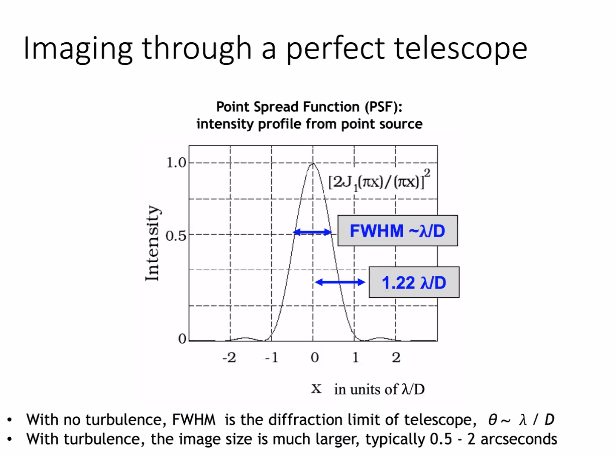


Groundbase telescope has it hard to eliminate aberration, as there are index of refraction fluctuations due to diferences in the atmosphere. Resulting images are a combination of many Airy disks at different locations this are called speckles.

Turbulence due to wind around the telescope dome is expected, in the atmosphere and up to the tropopause when turbulence peaks due to wind shear. Adaptative optics system allows to do live corrections as the mirror in the telescope adjust in real time

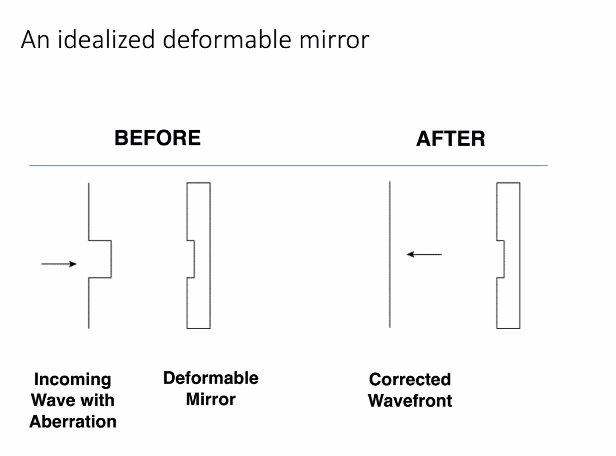

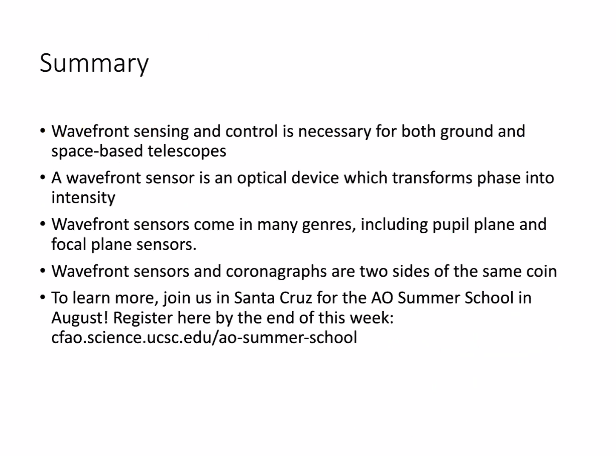




## &#128309; Setup Python running on your own computer directory

**Run the Next cell**

In [4]:
# Enter the full path to your PSF_Subtraction directory where you downloaded the data in the Setup notebbook
# For example:  '/Users/jsmith/PSF_Subtraction'
import os
absolute_path_to_the_data_folder_on_your_machine = '/home/fabian/Sagan_Workshop/SSW2024_notebooks/PSF_Substraction/' # Please complete!
os.chdir(absolute_path_to_the_data_folder_on_your_machine)

In [5]:
import os
os.getcwd()

'/home/fabian/Sagan_Workshop/SSW2024_notebooks/PSF_Substraction'

# The rest of the notebook cells are for &#128992; Colab or &#128309; running Python on your computer


# Import Packages

In [2]:
import numpy as np
import astropy.io.fits as fits
import scipy.ndimage
import pyklip.klip
import pyklip.parallelized
import pyklip.instruments.Instrument as Instrument
import pyklip.fakes
import pyklip.kpp.metrics.crossCorr
import pyklip.kpp.stat.statPerPix_utils


import matplotlib.pylab as plt
%matplotlib inline

# Read in the necessary data

We will read in three different files:

 1. A time series of the science data. This is a 3-D image cube consisting of images of the system taken over time. The sky rotates over this period of time due to angular differential imaging. If you look really carefully, you can actually see a couple of planets!
 2. An image of the star not blocked by the coronagraph, so we can measure the flux of the star. This is needed to measure flux ratio between the planet and the star.
 3. A 1-D array of parallactic angles. These angles specify the rotation of the sky for each frame in the 3-D image cube due to the Earth's rotation. These are needed to derotate the images so we can stack the signal of the planet together on the same pixel.

 Credit to William Thompson (https://www.astro.uvic.ca/~wthompson/) for reducing these HR 8799 datasets and putting them online for us.

Text(0.5, 1.0, 'Calibration Frame')

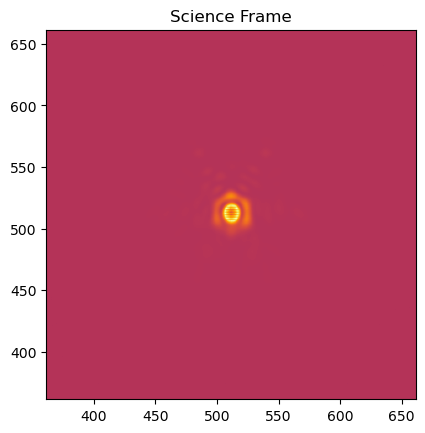

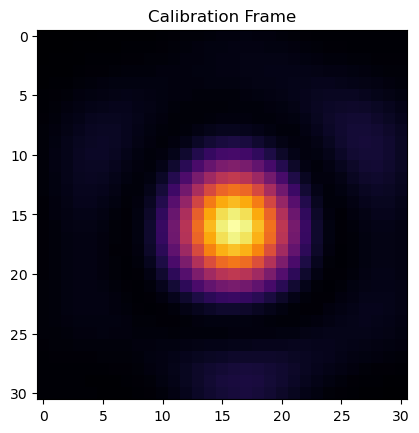

In [3]:
# load in the science frames for imaging the planet
with fits.open("Project_Materials_2009/center_im.fits") as hdulist:
    img_cube = hdulist[0].data # Series of images of the star system taken in time
    exptime = hdulist[0].header['ITIME'] * hdulist[0].header['COADDS']

# the location of the star behind the coronagraph based on the documentaion
star_centx = (img_cube.shape[2]-1)/2
star_centy = (img_cube.shape[1]-1)/2

# load in the calibration frame to calibrate the brightness of any sources with respect to the star
with fits.open("Project_Materials_2009/median_unsat.fits") as hdulist:
    calib_frame = hdulist[0].data # image of the unsaturated star for photometric calibration
    # crop it down because we don't need it so big
    calib_orig_cent = ((calib_frame.shape[0] - 1) // 2, (calib_frame.shape[1] - 1) // 2)
    stamprad = 15
    calib_frame = calib_frame[calib_orig_cent[0]-stamprad:calib_orig_cent[0]+stamprad+1, calib_orig_cent[1]-stamprad:calib_orig_cent[1]+stamprad+1]
    calib_exptime = hdulist[0].header['ITIME'] * hdulist[0].header['COADDS']

# the location of the star in the calibration frame
calib_centx = (calib_frame.shape[1]-1)/2
calib_centy = (calib_frame.shape[0]-1)/2

# the parallactic angles corresponding to each frame for angular differential imaging
with fits.open("Project_Materials_2009/rotnorth.fits") as hdulist:
    rot_angles = hdulist[0].data # negative signs are tricky

plt.figure()
plt.imshow(img_cube[0], cmap="inferno")
plt.xlim([star_centx-150, star_centx+150])
plt.ylim([star_centy-150, star_centy+150])
plt.title("Science Frame")

plt.figure()
plt.imshow(calib_frame, cmap="inferno")
plt.title("Calibration Frame")

# Science fram gives the central star with the diffracted starlight
# calibration frame is the image of the star without something blocking it

# Load in the data into `pyklip`

We need to specify the location of the star in each frame, and then pass the data into the `pyklip` framework, which standardizes data from many high-contrast imaging instruments

In [5]:
# Loading data
centers = np.array([[star_centx, star_centy] for _ in range(img_cube.shape[0])])
# dataset have I/O data of or cube image
dataset = Instrument.GenericData(img_cube, centers, parangs=rot_angles)
dataset.IWA = 25
dataset.OWA = 250

# Subtract off the stellar PSF

This parallelized code runs "KLIP" (basically PCA) to remove the glare of the star. Note that is might take a couple of minutes to run -- this is a computationally intensive method.

In [ ]:
# THis code takes a lot of memory, so it will not work on jupyter notebook it must be worked on google collab
pyklip.parallelized.klip_dataset(dataset, outputdir="./", fileprefix="epoch1", annuli=11,
                                 subsections=1, numbasis=[1,3,5,10,20,30], maxnumbasis=100, mode="ADI",
                                 movement=1)


Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 11
90.91% done (9/11 completed)
Closing threadpool
Derotating Images...


# Show the output image (residual map)

Do you see any planets? How many?

In [6]:
output_img = np.nanmean(dataset.output[-1,:,0], axis=0) # combine images in time
# output array

plt.figure()
plt.imshow(output_img, cmap="inferno", vmin=np.nanpercentile(output_img, 1), vmax=np.nanpercentile(output_img, 99.7))
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])
plt.title("Residual Map")
# output image with 4 planets  outter planet at ~(350,600)
# second planet at (575,590)
# third and fourth between 500-550 on x axis and 450-500 on y axis, bright spots 

TypeError: 'NoneType' object is not subscriptable

# Measure the raw position and brighness of a planet

The code below works for a single planet by fitting the planet to a 2-D Gaussian. We are calling it the "raw" position and brightness because the image subtraction process distortions and attenuates the planet PSF. Thus the position may be biased, and the raw planet is almost always lower than the true planet flux. We will want to do additional calibration (see below) before reporting any values.

**Note**: you need to change the `guess_x` and `guess_y` values for each planet you want to measure the properties. These two values are an approximate (x,y) pixel location for the position of the planet in the processed image shown above. The guess needs to be fairly accurate (< 10 pixels), so you may need to zoom into portions of the image (or open the output FITS file in the FITS viewer like DS9) to come up with a good guess.

**The code cell below will measure the planet's flux**

1.- compute the relative offset from the star

2.- output the separation (in milliarcseconds) and position angle (in degrees) of the planet with respect to the star. 

**Note that the planet flux is still in arbitrary detector units.**

In [7]:
# NON RUNNABLE CODE ON JUPYTER NOTEBOOK
guess_x, guess_y = 575, 583 # guess for planet in the most right part position
guess_flux = 800

raw_peakflux, fwhm, planet_x, planet_y = pyklip.fakes.gaussfit2d(output_img, guess_x, guess_y, guesspeak=guess_flux)
print(raw_peakflux, fwhm, planet_x, planet_y)

star_y, star_x = dataset.output_centers[0]

planet_sep_pixels = np.sqrt((planet_x - star_x)**2 + (planet_y - star_y)**2)
planet_PA = np.degrees(np.arctan2(-(planet_x - star_x), planet_y - star_y)) % 360

platescale = 9.952 # mas/pixel
planet_sep_mas = planet_sep_pixels * platescale

print("Planet separation: {0:.2f} mas. Planet PA: {1:.2f} deg".format(planet_sep_mas, planet_PA))

NameError: name 'output_img' is not defined

## Measure the signal-to-noise ratio (SNR) of the planet

We generally want to quantify the significance of the detection, even if we identify a planet by eye. To do this, it is common to measure the signal to noise ratio. There are two steps in measuring the signal to noise ratio.

Note that we don't need to calibrate the flux attenuation of the planet in order to measure SNR. This is because both the signal and noise are attenuated approximately by the same factor.

### Step 1: Use a planet detection algorithm on the image (optional)

The most naive option is to simply take the brightest pixel in the residual map. However, we know that planets should appear as point sources in the image. Thus, we should leverage the fact the planet flux spans multiple pixels in an image and has a distinctive shape (the shape of the point spread function). The point spread function can be obtained from unocculted images of the star (for most coronagraphs currently used, this is a good enough approximation of the planet PSF with the coronagraph in).

Once we have the template of what a planet signal should look like, we can search for that shape across the entire image. Some options to do this include cross correlation or matched filtering (these terms are nearly identical). A simple cross correlation with the residual map is the quickest to do, so we will do that here to create a cross correlation map.

(312.0, 712.0)

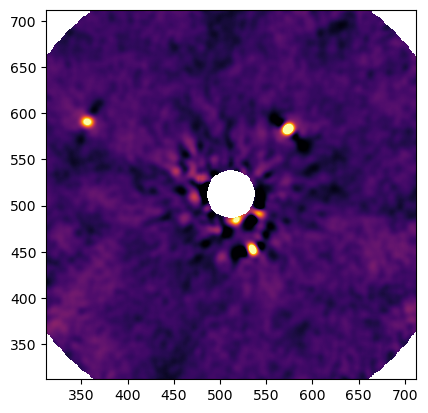

In [12]:
# planet detection algorithm applied on the image
# use the unocculted image of the star to create a template PSF
# we're just going to make a rough cutout to keep things simple
calib_centy_int = int(np.round(calib_centy))
calib_centx_int = int(np.round(calib_centx))
template = calib_frame[calib_centy_int-10:calib_centy_int+11, calib_centx_int-10:calib_centx_int+11]

# perform a cross correlation of the image with a planet template to get a cross correlation map
# this helps us filter out noise
cc_map = pyklip.kpp.metrics.crossCorr.calculate_cc(output_img, template, nans2zero=True)

plt.imshow(cc_map, cmap="inferno", vmin=np.nanpercentile(cc_map, 0.5), vmax=np.nanpercentile(cc_map, 99.9))
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])

### Step 2: Compute a SNR map from your detection map

The SNR map at each pixel i can be computed from the cross correlation map (cc) and a noise map ($\sigma$).

$$ SNR_i = \frac{cc_i}{\sigma_i} $$

To compute the noise map, we usually assume the noise is azimuthally symmetric. That is, each concentric annulus around the star has the same noise properties. This means we can take the standard deviation of the annulus to estimate the noise for all pixels in that annulus.

Note that if there is a planet in an annulus, the noise you measure in that annulus will be artificially enhanced. There are several ways around this. The simplist is to mask out any potential planets in your image before computing the noise in each annulus. A more rigorous apporach is to compute the noise on a pixel by pixel basis, masking out a region around the pixel where a possible planet could be. However, the latter apporach drastically increases the computation time. We skip doing either here, so our SNR of our planets will be slightly underestimated here, because our noise will be overestimated.

/home/fabian/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(312.0, 712.0)

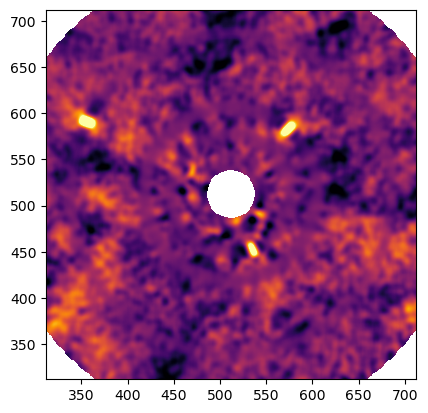

In [13]:
# Cross correlate image with the star
SNR_map = pyklip.kpp.stat.statPerPix_utils.get_image_stat_map(cc_map,
                                           centroid = dataset.output_centers[0],
                                           r_step=2,
                                           Dr = 2,
                                           type = "SNR")

plt.imshow(SNR_map, cmap="inferno", vmin=-2.5, vmax=5)
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])

# This smooth aout the noise, by normalizing the noise, 
# We assume that further from the star the noise gets lower
# signals at the outskirts of the central image are brighter to detect planets in a clear way
# in our original image planets where about the same brightness due to contrast with star
# now we truly can observe the planet 
# system HR 8799 initially show only 3 planets, now in the 2021 data we know that there is 4 planets

In [14]:
# read off the SNR map to get the SNR of the planet you care about.
# we will perform the "read off" using a linear interpolation to the centroid location of the planet

SNR_map[np.where(np.isnan(SNR_map))] = 0 # have to mask NaNs for this to work
planet_snr = scipy.ndimage.map_coordinates(SNR_map, [[planet_y], [planet_x]])
print(planet_snr)

# this measures the SNR for the right most planet
# this can be used for the other planets
# the results gives 8, so we have a good detection

[8.60396114]


# Inject Synthetic Planets to Calibrate Planet Properties

As mentioned previously, image subtraction distorts and attenuates any astrophysical signals such as planets in the image. This is due to two factors:

 * Over-subtraction: when we scale the intensity of any model image of the stellar diffraction to match the science image, so we can subtract off the flux, the scale factor will be biased if an additional astrophysical signal exists in the data. It will cause the scale factor to be overestimated, which causes some planet flux to be subtracted off. This applies to ADI, SDI, and RDI.
 * Self-subtraction: when we built a model of the stellar diffraction using images with astrophysical sources in it, those sources will leak into the model. Scaling the model with remnants of additional astrophysical signal in it will cause the artifacts in the image (see the negative lobes on either side of the planet azimuthally in the images above). This applies to ADI and SDI, but not RDI. Note that this effect is typically more severe than the over-subtraction effect.

To correct for these biases, we inject planets with known fluxes and positions into the data. To characterize the flux and position of a planet, we want to inject synthetic planets at many other azimuthal positions, but the same radial distance from the star. We re-run image subtraction with the data augmented with simualted planets, measure the properties of the planets, and compare against the inejcted values to determine the biases. This makes the assumption the noise is azimuthally symmetric around the star (which is usually a decent assumption). Below, we will inject two synthetic planets into one dataset. For publications, we generally inject many more (multiple reductions where each time we place a synthetic planet at a different resolution element).

## Inject synthetic planets into the data

Each high contrast instrument should have a way to obtain an measurement of the star without the coronagraph. This is used for photometric calibration as well as determing the point spread function (PSF) of what a planet that isn't behind the coronagrpah looks like.

For Keck, we can take a frame of the star using a much shorter exposure time, so it doesn't saturate the detector. We can scale the flux of the star by the exposure times to match what the flux of the star would be in each science frame if detectors don't saturate. Then, we can scale down the flux to simualte a planet, and inject it into a position around the star.


In [15]:
# Measure the flux of the star without the coronagrpah but taken with a different exposure time
peakflux_star, _, _, _ = pyklip.fakes.gaussfit2d(calib_frame, calib_centx, calib_centy, guesspeak=10000)

# Scale the star to the approximate brightness of the planet (in detector units)
planet_template = calib_frame * (raw_peakflux)/(peakflux_star)

# create a new dataset for synthetic planet injection
fakes_dataset = Instrument.GenericData(np.copy(img_cube), centers, parangs=rot_angles)
fakes_dataset.IWA = 25
fakes_dataset.OWA = 250

# Inject the synthetic planet at 90 degrees away from the real planet, but at the same separation
planet_template_cube = np.array([planet_template for frame in fakes_dataset.input]) # a PSF template for each frame
pyklip.fakes.inject_planet(fakes_dataset.input, fakes_dataset.centers, planet_template_cube, dataset.wcs, planet_sep_pixels, planet_PA + 90)

# Inject another planet at -90 degrees away
pyklip.fakes.inject_planet(fakes_dataset.input, fakes_dataset.centers, planet_template_cube, dataset.wcs, planet_sep_pixels, planet_PA - 90)

## Run KLIP on Synthetic Planet Dataset

It is important that we use the same reduction parameters as for the analysis on the real planets.

You should check that you see the planets you injected into the data in this reduction.

This apply the same code that takes a while and cannot be run on jupyter notebook

In [8]:
pyklip.parallelized.klip_dataset(fakes_dataset, outputdir="./", fileprefix="fakepl_epoch1", annuli=11,
                                 subsections=1, numbasis=[1,3,5,10,20,30], maxnumbasis=100, mode="ADI",
                                 movement=1)

fakes_output_img = np.nanmean(fakes_dataset.output[-1,:,0], axis=0) # combine images in time

plt.figure()
plt.imshow(fakes_output_img, cmap="inferno", vmin=np.nanpercentile(fakes_output_img, 1), vmax=np.nanpercentile(fakes_output_img, 99.7))
plt.xlim([fakes_dataset.output_centers[0,0]-200, fakes_dataset.output_centers[0,0]+200])
plt.ylim([fakes_dataset.output_centers[0,1]-200, fakes_dataset.output_centers[0,1]+200])
plt.title("Stellar PSF Subtracted Image with Fakes")
# injecting 2 fake planets, they must be atleast SNR=5 as that is a decent detection

NameError: name 'fakes_dataset' is not defined

## Measure the properties of the synthetic(fake) planets

We want to measure flux, separation, and PA for them just like the real planets. In this case, we also know the answer.

In [ ]:
fake_input_pas = [planet_PA + 90, planet_PA - 90]
fake_measured_peakfluxes = []
fake_measured_seps = []
fake_measured_PAs = []

for this_fake_pa in fake_input_pas:
    # figure out guess location for gaussian fit using the known location
    # convert sep/PA to x/y
    star_y, star_x = fakes_dataset.output_centers[0]
    fake_input_x = -planet_sep_pixels * np.sin(np.radians(this_fake_pa)) + star_x
    fake_input_y = planet_sep_pixels * np.cos(np.radians(this_fake_pa)) + star_y

    fake_raw_peakflux, fake_fwhm, fakeplanet_x, fakeplanet_y = pyklip.fakes.gaussfit2d(fakes_output_img, fake_input_x, fake_input_y, guesspeak=guess_flux)

    fake_sep_pixels = np.sqrt((fakeplanet_x - star_x)**2 + (fakeplanet_y - star_y)**2)
    fake_planet_PA = np.degrees(np.arctan2(-(fakeplanet_x - star_x), fakeplanet_y - star_y)) % 360

    fake_planet_sep = fake_sep_pixels * platescale

    fake_measured_seps.append(fake_planet_sep)
    fake_measured_PAs.append(fake_planet_PA)
    fake_measured_peakfluxes.append(fake_raw_peakflux)


## Measure the calibrated flux ratio of the planet relative to the star

Ok! We can finally go back to finalizing the measurements of the real planet!

Now that we have measured the synthetic planets, we can see how much fainter they are on average compared to their injected brigthnesses. The multiplicative difference is what we call "algorithm throughput," which is the correction factor we can apply to the true planet to get the unbiased planet flux. As you see below, the algorithm throughput is a significant factor! The equation below summarizes this:

$ \textrm{planet_to_star_ratio} = \frac{\textrm{planet_flux}/\textrm{algorithm_throughput}}{\textrm{star_flux}} $

We can also use the scatter in the synthetic planet measurement to estimate the uncertainty of the flux measurement. Of course, for a publication-grade analysis, we want many more than just 2 synthetic planets to estimtae the uncertainity! This is also just the statistical uncertainity in the planet flux. We can usually safely assume the algorithm throughput error and star flux error are much smaller, but it is always good to check. Furthermore, there are often systematic photometric calibration uncertainties that are reported for each instrument that should also be folded in.

$ \textrm{planet_to_star_ratio_error} = \frac{\textrm{planet_flux_error}/\textrm{algorithm_throughput}}{\textrm{star_flux}} $

In our analysis here, we also have to account for different exposure times.


In [ ]:
algo_throughput = np.mean(fake_measured_peakfluxes)/raw_peakflux # since we injected the planet with raw_peakflux brightness
flux_ratio = (raw_peakflux/exptime) / algo_throughput / (peakflux_star/calib_exptime)
print("algo throughput", algo_throughput)
print("flux ratio", flux_ratio)
# This is called angular differential imaging

## Measure the bias and error on the separation and PA of the planet

We can do the same thing to measure bias and erro on the separation and PA. For each planet, it's at the same separation and different, but known, PAs. So we can see how far off each measurement is.

In this analysis, the bias is much smaller than the unceratinity. We will simply say the bias is 0, as it is consistent with no bias.

Note that this is just the statistical precision on the location of the planet. We obtain relative astrometry (the offset between the star and planet), we need to fold in the uncertainty in the location of the star, the uncertainity in the platescale, and uncertainity in the North angle. This is left as an exercise to the reader.



In [ ]:
sep_bias = np.mean(fake_measured_seps) - planet_sep_mas
sep_err = np.std(fake_measured_seps)

pa_bias = np.mean(fake_measured_PAs - np.array(fake_input_pas) % 360)
pa_err = np.std(fake_measured_PAs - np.array(fake_input_pas) % 360)

print("sep bias: {0:.2f} mas, sep err: {1:.2f} mas".format(sep_bias, sep_err))
print("PA bias: {0:.2f} deg, PA err: {1:.2f} deg".format(pa_bias, pa_err))

# Measure post-processed contrast curves

Contrast curves describe the sensitivity of the dataset. In our field, we nominally use a "5-sigma" threshold for quantifying sesntivity. It means we claim we are not sensitive to any planets that are less than 5 standard deviations brighter than the noise. This is a rough approximation of our sensitivity when we do planet detection by eye, but it is an approximation.

Note: There are more accurate and procedural versions that we will not go into here (perhaps a good project?). The systematic way to determine sensitivity is to have a planet detection algorithm (e.g., the cross correlation maps we derived above), determine a detection threshold for your algorithm based on how many candidates your imaging program can follow up (this could be above or below 5-sigma), follow-up to confirm/reject candidates, and publish your sensitivity curves using your detection threshold.

## Generate a post-processed 1-D contrast curve

We will use the code below to generate a post-processed contrast curve. It is a 1-D curve because it assumes the noise is azimuthally symmetric. We need to specify the resolution of our data (the FWHM of a PSF), because we need to correct for small number statistics (see https://iopscience.iop.org/article/10.1088/0004-637X/792/2/97). This accounts for the fact that our estimate of the standard deviation of the noise is uncertain because of our limited number of independent samples of the noise. We also smooth the image (low pass filter) slightly to average out pixel-to-pixel noise due to things like detector noise. This is something we do by eye anyways, so we are reflecting that.

The contrast curve assumes there are no planets in the data (we are just measuring noise). But there are planets in the data! This will bias the contrast curve, creating bumps you see below. Project: mask out these planets to better measure contrast.

The uncalibrated post-processed contrast curve we derive is also attenuated by oversubtraction and selfsubtraction so we need to correct for algorithm throughput just like flux. We do that and convert from counts to flux ratio.

In [ ]:
dataset_fwhm = fwhm
low_pass_size = 1
contrast_seps, uncalib_contrast_dn = pyklip.klip.meas_contrast(output_img, dataset.IWA, dataset.OWA,
                                             dataset_fwhm, center=dataset.output_centers[0],
                                             low_pass_filter=low_pass_size)

calib_contrat_fluxratio = (uncalib_contrast_dn/exptime) / algo_throughput / (peakflux_star/calib_exptime)

plt.figure()
plt.plot(contrast_seps, calib_contrat_fluxratio, 'b-')
plt.ylabel("5-sigma contrast")
plt.xlabel("Separation (pixels)")
plt.yscale("log")
# A lot of PSF substraction packages, the one we are using is kinda comfortable to use, that's why is usefull

# Group Project Ideas

The difficulty of the project ideas increase as the list goes down.

### 1. Compare planet SNR between epochs

In the data you downloaded, there is also a 2021 dataset (for the demo above, we looked at the 2009 dataset). Run KLIP on the 2021 dataset. Measure the SNR of the same planet in the 2021 dataset. Is the SNR better or worse? (Note: your personal computer may run out of memory running the 2021 dataset, in which case you should run it on Google Colab).

Bonus: Do this for all four planets. Is there the same difference in SNR across all four planets?


### 2. Estimate planet masses

Measure the calibrated flux ratio of the outermost planet. Note that you need to measure and correct the algorithm throughput for this planet separately (each planet will have a its own algorithm throughput factor).

Using its flux ratio, use the [SSW2024_PlanetIsochrones.ipynb](https://colab.research.google.com/drive/11td2wSDbCXxRD_vonaC30styonLovXol?usp=sharing) notebook to derive a planet mass for both planets. 

How do they compare to values measured in the literature? Bonus: the age of the planets is uncertain -- what happens to our mass estimate if we assume an age that is 2x yougner and 2x older?

**Notes**

* Planet C and B are to be compared
* for that we observe the outermost planet, change the ~300 guess value on x and ~600 for y
* flux measure, inject fake planets with same separation as outermost planet
* With that measure the algorithm and flux ratio with those values

**Second step**

* open up Isochrones notebook
* go to convert measured L band flux ratio to a planet absolute magnitude
* change planet_fluxratio value for the one derived in the past step


### 3. Trace out the orbit of a planet

In the data you downloaded, there is also a 2021 dataset (for the demo above, we looked at the 2009 dataset). For one of the planets, measure its relative astrometry in both the 2009 and 2021 data. You should reduce the 2021 data in the same way as you reduced the 2009 data. After you obtained both epochs, use the [SSW2024_OrbitFitting.ipynb](https://colab.research.google.com/drive/1N6UTxFsShe1dLeAIVpjW_sf94--djKlq?usp=sharing) notebook to perform an orbit fit. In that notebook, you will be asked to supply errors on your measurements: use 10 milliarcseconds as the error in separation and 1 degree as the error in PA. Make a plot of what the orbit looks like on the sky and record your estimate of the semi-major axis.  (Note: your personal computer may run out of memory running the 2021 dataset, in which case you should run it on Google Colab).


Bonus: do this for all four planets and compare your measured semi-major axis values to the values determined in the literature. How close were you?


